In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss

In [3]:
covertype = sklearn.datasets.fetch_covtype()

In [4]:
_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

In [5]:
indices = list(torch.utils.data.WeightedRandomSampler(weights, 7000))

In [6]:
raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

In [7]:
tsne = sklearn.manifold.TSNE(perplexity=200, init='pca')
emb = tsne.fit_transform(data)

c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:>

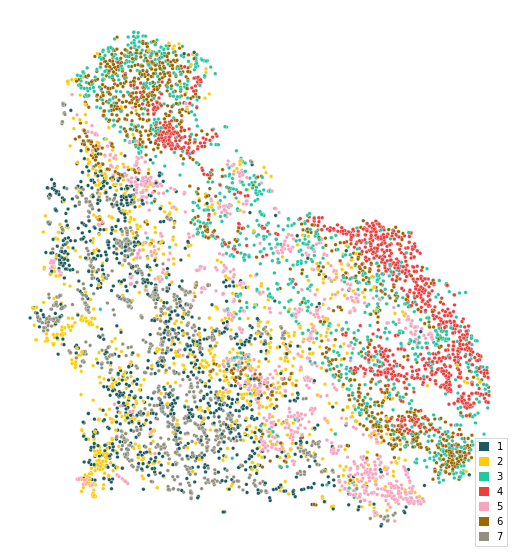

In [9]:
paradime.utils.plotting.scatterplot(emb, covertype.target[indices])

In [11]:
pd_tsne = paradime.dr.ParametricDR(
    global_relations=paradime.relations.NeighborBasedPDist(
        transform=[
            paradime.transforms.PerplexityBasedRescale(
                perplexity=200,
                bracket=[0.001,1000]
            ),
            paradime.transforms.Symmetrize(),
            paradime.transforms.Normalize(),
            ]
        ),
    batch_relations=paradime.relations.DifferentiablePDist(
            transform=[
                paradime.transforms.StudentTTransform(alpha=1.),
                paradime.transforms.Normalize(),
                paradime.transforms.ToSquareTensor(),
            ]
        ),
    in_dim=10,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=data,
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({
    'pca': sklearn.decomposition.PCA(n_components=2).fit_transform(data)
})
pd_tsne.add_training_phase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key='pca'),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)
pd_tsne.add_training_phase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)
pd_tsne.train()

2022-08-27 00:38:50,499: Registering dataset.
2022-08-27 00:38:50,507: Adding entry 'pca' to dataset.
2022-08-27 00:38:50,509: Computing global relations 'rel'.
2022-08-27 00:38:50,509: Indexing nearest neighbors.
2022-08-27 00:39:12,855: Calculating probabilities.
2022-08-27 00:39:13,932: Beginning training phase 'pca_init'.
2022-08-27 00:39:15,880: Loss after epoch 0: 17.95099936425686
2022-08-27 00:39:16,308: Loss after epoch 5: 0.020455967634916306
2022-08-27 00:39:16,797: Beginning training phase 'embedding'.
2022-08-27 00:39:18,442: Loss after epoch 0: 0.050688446033746004
2022-08-27 00:39:21,506: Loss after epoch 2: 0.04467683471739292
2022-08-27 00:39:24,704: Loss after epoch 4: 0.043497508158907294
2022-08-27 00:39:27,669: Loss after epoch 6: 0.04271294502541423
2022-08-27 00:39:30,841: Loss after epoch 8: 0.04217137792147696
2022-08-27 00:39:34,091: Loss after epoch 10: 0.04173716646619141
2022-08-27 00:39:37,170: Loss after epoch 12: 0.041055843932554126
2022-08-27 00:39:40,

<AxesSubplot:>

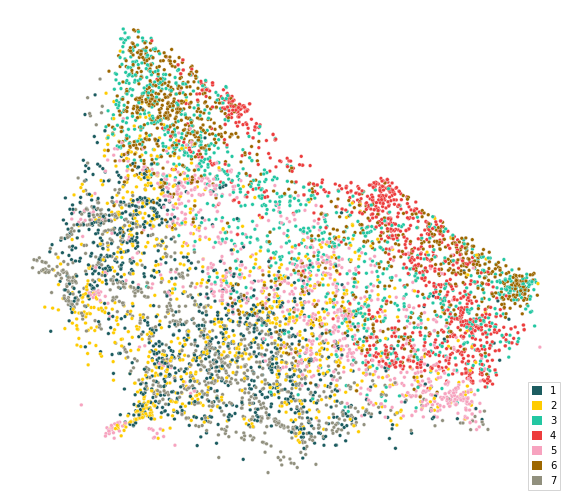

In [12]:
paradime.utils.plotting.scatterplot(
    pd_tsne.apply(data),
    labels=covertype.target[indices]
)

In [54]:
class SupervisionLoss(paradime.loss.Loss):
    """A simple supervision loss.

    This loss computes the summed up norms of the standard deviations of item
    subsets with equal labels. This should pull clusters of
    equally labeled items closer together. In order to not pull all items
    towards zero, the standard deviation of all items should simultanesously be
    equal to a given constant.

    Args:
        labels: A list of unique labels used to extract the item subsets.
        total_std: The target norm of the standard deviation of the whole
            embedded batch.
        repulsion: Factor to weight the repulsion with.
        data_key: The key under which to find the data in the input batch.
        label_key: The key under which to find the labels in the input batch.
        name: Name of the loss (used by logging functions).
    """

    _prefix = "supervised_loss"

    def __init__(
        self,
        total_std=1.,
        repulsion=5.,
        data_key="data",
        label_key="labels",
        name=None,
    ):
        super().__init__(name)

        self.total_std = total_std
        self.repulsion = repulsion
        self.data_key = data_key
        self.label_key = label_key

    def forward(
        self,
        model,
        global_relations,
        batch_relations,
        batch,
        device,
    ) -> torch.Tensor:

        data = batch[self.data_key].to(device)
        emb = model.forward(data)
        target_std = torch.full_like(emb[0], self.total_std)
        repulsion = torch.tensor(self.repulsion, device=device)

        labels = batch[self.label_key]
        unique_labels = np.unique(labels)
        loss = torch.tensor(0., dtype=torch.float, device=device)
        for i in unique_labels:
            loss = loss + emb[np.where(labels == i)].std(axis=0).norm()
        loss = loss + (repulsion
            * torch.norm((emb.std(axis=0) - target_std))
        )
        
        return loss

In [64]:
pd_tsne = paradime.dr.ParametricDR(
    global_relations=paradime.relations.NeighborBasedPDist(
        transform=[
            paradime.transforms.PerplexityBasedRescale(
                perplexity=200,
                bracket=[0.001,1000]
            ),
            paradime.transforms.Symmetrize(),
            paradime.transforms.Normalize(),
            ]
        ),
    batch_relations=paradime.relations.DifferentiablePDist(
            transform=[
                paradime.transforms.StudentTTransform(alpha=1.),
                paradime.transforms.Normalize(),
                paradime.transforms.ToSquareTensor(),
            ]
        ),
    in_dim=10,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=data,
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({
    'pca': sklearn.decomposition.PCA(n_components=2).fit_transform(data),
    'labels': covertype.target[indices],
})
pd_tsne.add_training_phase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key='pca'),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)
pd_tsne.add_training_phase(
    name="embedding",
    loss=paradime.loss.CompoundLoss([
        paradime.loss.RelationLoss(
            loss_function=paradime.loss.kullback_leibler_div
        ),
        SupervisionLoss()
    ], weights=[5000,1]),
    batch_size=500,
    epochs=20,
    learning_rate=0.02,
    report_interval=2,
)
pd_tsne.train()

2022-08-27 01:34:55,674: Registering dataset.
2022-08-27 01:34:55,686: Adding entry 'pca' to dataset.
2022-08-27 01:34:55,686: Adding entry 'labels' to dataset.
2022-08-27 01:34:55,687: Computing global relations 'rel'.
2022-08-27 01:34:55,688: Indexing nearest neighbors.
2022-08-27 01:35:04,488: Calculating probabilities.
2022-08-27 01:35:05,309: Beginning training phase 'pca_init'.
2022-08-27 01:35:05,425: Loss after epoch 0: 14.225926339626312
2022-08-27 01:35:06,002: Loss after epoch 5: 0.014363624970428646
2022-08-27 01:35:06,590: Beginning training phase 'embedding'.
2022-08-27 01:35:08,319: Loss after epoch 0: 500.3922309875488
2022-08-27 01:35:11,504: Loss after epoch 2: 452.0012493133545
2022-08-27 01:35:14,820: Loss after epoch 4: 447.5142421722412
2022-08-27 01:35:18,169: Loss after epoch 6: 447.2802104949951
2022-08-27 01:35:21,401: Loss after epoch 8: 445.5256767272949
2022-08-27 01:35:24,754: Loss after epoch 10: 444.925048828125
2022-08-27 01:35:28,001: Loss after epoch 

<AxesSubplot:>

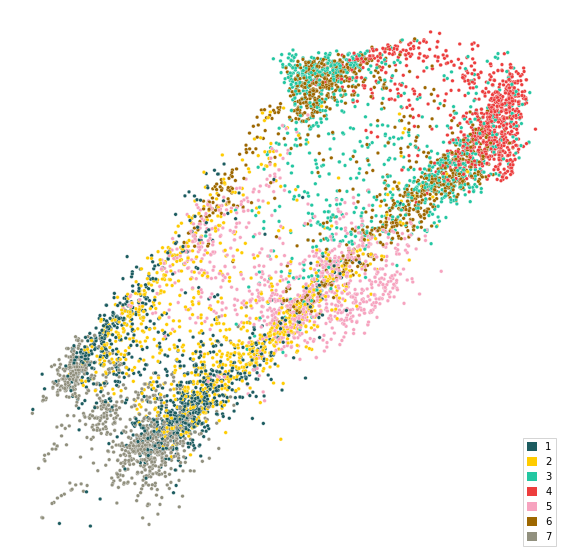

In [65]:
paradime.utils.plotting.scatterplot(
    pd_tsne.apply(data),
    labels=covertype.target[indices]
)